## **Euler's Method for solving ODEs**
---

- **Key Takeaways**
    - `t[i+1] = t[i]+dt`
    - `x[:,i+1] = x[:,i] + dt*f(x[:,i], params, t[i])`
- **Math expressions**
$$
\begin{aligned}
t_{i+1} &= t_i + dt\\
x_{i+1} &= x_i + dt \cdot f'(x)
\end{aligned}
$$

In [10]:
using Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra
include("src/manipulator_library.jl")

cleanUp (generic function with 2 methods)

In [11]:
gr()

# Single-link Pendulum Model

struct ParamsPendulum
    m::Float64      # Mass in kilograms
    L::Float64      # Length in meters
    g::Float64      # Acceleration due to gravity in m/s^2
end


# Initialize the Params structure with specific values
m = 2
L = 1
g = 9.81
params = ParamsPendulum(m, L, g)


# define the ODE dx/dt = f(x,params,t)
function f(x, params, t) 
    dx = [x[2], -(params.g/params.L)*sin.(x[1])]
    return dx
end

# Set the initial condition as a vector
x0= [3*pi/8; 0.0]

# Set the time interval
T = (0.0, 10) 

(0.0, 10)

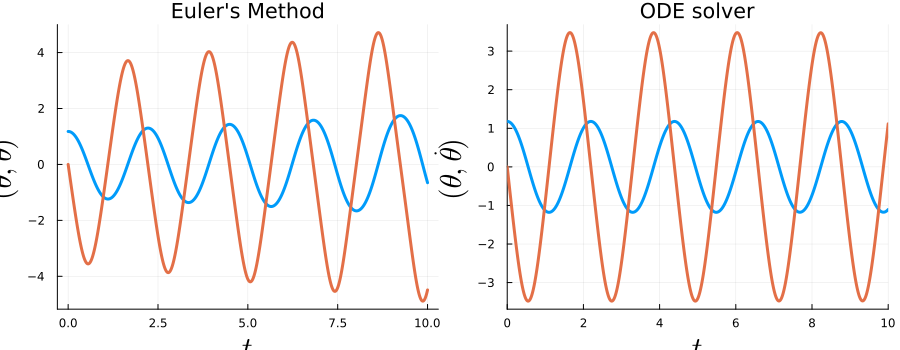

In [12]:
#========================== EULER METHOD ==========================#
dt = 1e-2
N = floor(Int64, T[2]/dt)
x = zeros(2,N+1)
x[:,1] = x0
t = zeros(N+1)
t[1] = T[1]
for i in 1:N
    t[i+1] = t[i]+dt
    x[:,i+1] = x[:,i] + dt*f(x[:,i], params, t[i])
end
#==================================================================#
#======================= ODE SOLVER METHOD ========================#
prob = ODEProblem{false}(f, x0, T, params)
sol = solve(prob, Tsit5())
#==================================================================#

p1 = plot(t, x', lw=3, guidefont = 20, title="Euler's Method", xlabel=L"t", ylabel=L"(\theta, \dot{\theta})", legend=false)
p2 = plot(sol, lw=3, guidefont = 20,  title="ODE solver", xlabel=L"t", ylabel=L"(\theta, \dot{\theta})", legend=false)
plot(p1, p2, layout=(1, 2), size=(900, 350))

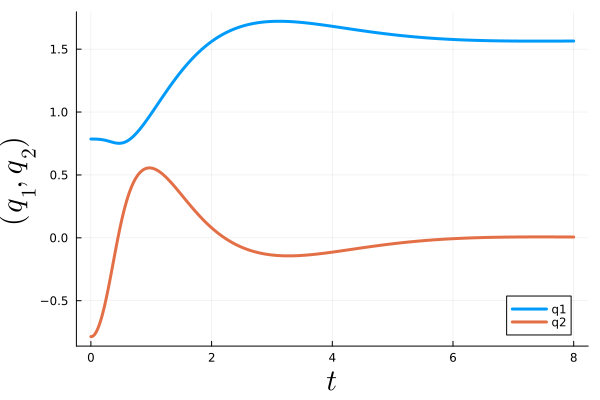

In [13]:
gr()

#Build a function to define the parameters of the model
function modelParameters()
    g = 9.81 # m/s^2
    L1 = 1 # m
    L2 = 0.7
    m1 = 15 # kg
    m2 = 10   
    return g, L1, L2, m1, m2
end

# Parameters for the Feedback controller

struct Params2L
    qe::Vector{Float64}      # equilibrium point
    K ::Matrix{Float64}      # LQR Feedback gain matrix
end
# Initialize the Params structure with specific values

K=[ 357.82  80.57  62.084   16.8291
  80.57  73.57  16.8291   6.92965]
qe = [pi/2, 0] # upward
params = Params2L(qe, K)


# define the ODE dx/dt = f(x,t)
#
# the parameters are passed via modelParameters() in the
# function dyn_mod_2LinkManipulator(q, dq)
#
function f(x,params,t)
    n = floor(Int, length(x) / 2) # In Julia n/2 is a Float64
    q = x[1:n]
    dq = x[n+1:end]
    K = params.K 
    qe = params.qe
    xe = [qe; 0*qe]
    tau = -K*(x-xe)
    model = dyn_mod_2LinkManipulator(q, dq)     
    dx1 = dq
    dx2 = (model.D) \ ( -model.C*dq-model.G+model.B*tau) # note the use of backslash
    dx=[dx1;dx2]
    return dx
end

# Set the initial condition as a vector
x0= [qe;0*qe] - [pi/4; pi/4; 0; 0]

# Set the time interval
T = (0.0, 8) 

# Euler's method
dt = 1e-2
N = floor(Int64,T[2]/dt)
x=zeros(4,N+1)
x[:,1]=x0
t=zeros(N+1)
t[1] = T[1]
for n=1:N
    t[n+1] = t[n]+dt
    x[:,n+1] = x[:,n] + dt*f(x[:,n],params,t[n])
end
#p1 = plot(t, x[1:2,:]', lw=3, guidefont = 20,  xlabel=L"t", ylabel=L"(q_1, q_2)", legend = ("q_1", "q_2"))
p1 = plot(t, x[1, :], lw=3, label="q1", guidefont=20, xlabel=L"t", ylabel=L"(q_1, q_2)",)
plot!(p1, t, x[2, :], lw=3, label="q2")